# 1. Overview of Chatbot Personality Analysis

This notebook provides an overview of this research product by describing the research questions, the data gathered, and the analysis conducted. Each research question is addressed in a separate notebook as follow:
  
<code>
1_RQ1_user_experience.ipynb 
2_RQ2_personality_simulation.ipynb 
3_RQ3_user_personality.ipynb 
</code>


# 2. Research Questions

#### RQ1: Does the personality demonstrated by a chatbot affect the user’s experience?

- Which chatbot did the participant prefer? (show counts for each chatbot - bar chart, pie chart, ratio etc.)
    - How does this align with the participant's personality? (correlation between extraversion and preference, agreebleness and preference, can use logistic regression or point biserial correlation)
- Is the preferred chatbot experience positively correlated with conversation engagement metrics such as conversation length? (logistic regression)


#### RQ2: Can Personality be simulated by a chatbot?

- Do participants reliably identify differences between chatbot personality?
- Do participants prefer one chatbot over the other because of its personality?

#### RQ3: Can a user’s personality be inferred through their interaction with a chatbot?

- Do self-described personality traits (beliefs) correlate with interaction metrics (behaviour)?
- Can we use NLP on participant utterances to extract personality traits?
    - How do extracted personality traits correlate with self-described personality traits?


# 3. Data Gathered

Data for this analysis was gathered via an online user study in which participants interacted with two chatbots designed with disctinct personalities. The personalities differ across two factors of the Big 5 Personality Trait model (https://en.wikipedia.org/wiki/Big_Five_personality_traits). These factors are Extroversion (outgoing/energetic vs. solitary/reserved) and Agreeableness (friendly/compassionate vs. challenging/detached). Participants filled out a demographic and personality survey before interacting with the chatbots. After each interaction the participants filled out a survey about how they perceived the chatbot they just used. At the end of the experiment participants filled out a final survey describing which chatbot they preferred. 

# 4. Analysis

We analysis survey responses (text) as well as conversation logs (json). We extract features from the json data including number of conversation turns, average length of user utterances etc. 

### Read in dialog files (JSON)


Each user utterance in a conversation is stored in a separate JSON file which contains fields about the message, the user, and the conversation:

Message:
- type
- ID
- timestamp
- Text

User:
- ID
- Name

Conversation:
- ID

Bot:
- ID
- Name


In [1]:
import json
from pandas.io.json import json_normalize
import os
import logging
import logging.handlers
import pandas as pd
import numpy as np
import glob
from datetime import datetime,timedelta
from collections import Counter
import nltk 
from functools import reduce
import re
from scipy.stats import pointbiserialr
import plotly.express as px
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

# Unpickle Anonymised Data

### Demographic Dataframe
This data was collected from the Pre-Interaction survey taken by the participants.
The data has been anonymised, and stored in a dataframe with the following columns:

- Timestamp (The time they began taking the survey)
- Age 
- Gender
- Do you know what a chatbot is? 
- If Yes, describe your understanding of what a chatbot is
- How often do you use Siri, Alexa, Google Assistant or any other virtual assistant?
- Their answers to a range of personality questions 



In [2]:
#unpickle df_dem
df_dem = pd.read_pickle("./df_dem.pkl")

### Interaction DataFrames

This code parses the json files from the chatbot interactions and stores the data in a dataframe with the following columns:

- Duration (Lenght of conversation in minutes)
- Chatbot (Name of chatbot)
- NumberOfTurns (absolute count of conversation turns made by the participant)
- Utterance (A list of all the participant's utterances)
- Word Count (Total word count of all the participant's utterances (sum))
- Average Utterance Length (The average character length of the participant's utteranes (mean))




In [3]:
#unpickle df_chatbotdata
df_chatbotdata = pd.read_pickle("./df_chatbotdata.pkl")
# convert duratin to minutes from ns
df_chatbotdata = df_chatbotdata.astype({'Duration': 'timedelta64[m]'})

### Complete Data

This data comprises of all four surveys taken by the particpants and the data collected from their interactions with the chatbots

In [4]:
#unpickle df_merged
df_merged = pd.read_pickle("./df_merged.pkl")
df_merged = df_merged.astype({'Duration_x': 'timedelta64[m]'})
df_merged = df_merged.astype({'Duration_y': 'timedelta64[m]'})

# Demographic Visualisations

### Bar Chart to depict the Age Distribution of the participants

In [211]:
# Age
fig = px.histogram(df_dem, x="Age")
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Age Distribution of Participants",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
   
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()

### Bar Chart to depict the Gender Distribution of the participants

In [210]:
fig = px.histogram(df_dem, x="Gender")
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Gender distribution of Participants",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    
   
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()

### Bar Chart to depict how often the partipants use a chatbot

In [209]:
fig = px.histogram(df_dem, x='How often do you use Siri, Alexa, Google Assistant or any other virtual assistant?')
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Frequency distribution of chatbot usage",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
       xaxis_title = "Frequency of chatbot use",
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()

### Pie Chart to depict if the particpants knew what a chatbot was

In [208]:
labels = df_dem['Do you know what a chatbot is?'].value_counts().index
values = df_dem['Do you know what a chatbot is?'].value_counts().values

fig = px.pie(labels=labels, values=values, names=labels)
fig.update_layout(
    width=600,
    height=650,
    title={
        'text': "Do you know what a chatbot is?",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()

## Personality Assignment

Automation of the Big Five Inventory Scoring Key: (https://fetzer.org/sites/default/files/images/stories/pdf/selfmeasures/Personality-BigFiveInventory.pdf)

In [9]:
extraversion = ((6 - df_dem['I am reserved']) 
        + df_dem['I am full of energy'] 
        + df_dem['I generate a lot of enthusiasm '] 
        + (6 - df_dem['I tend to be quiet ']) 
        + df_dem['I have an assertive personality'] 
        + (6 - df_dem['I am sometimes shy, inhibited']) 
        + df_dem['I am outgoing, sociable '])


df_dem["extraversion_score"] = extraversion
df_merged["extraversion_score"] = extraversion
               
               
agreeableness = ((6 - df_dem['I tend to find fault with others']) 
        + df_dem['I am helpful and unselfish with others']
        + (6 - df_dem['I start quarrels with others'] )
        + df_dem['I have a forgiving nature'] 
        + df_dem['I am generally trusting'] 
        + (6 - df_dem['I can be cold and aloof '])
        + df_dem['I am considerate and kind to almost everyone']
        + ( 6 - df_dem['I am sometimes rude to others']) 
        + df_dem['I like to cooperate with others'])
df_dem["agreeableness_score"] = agreeableness
df_merged["agreeableness_score"] = agreeableness


### Personality of Particpants (Extraversion)

In [206]:
counts, bins = np.histogram(df_dem['extraversion_score'], bins=range(0, 55, 5))
bins = 0.5 * (bins[:-1] + bins[1:])
fig = px.bar(x=bins, y=counts, labels={'x':'Extraversion Score', 'y':'count'})
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Distribution of Participant's Extraversion Scores",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()


### Personality of Particpants (Agreeableness)

In [205]:
# Personality of Participants 
counts, bins = np.histogram(df_dem['agreeableness_score'], bins=range(0, 55, 5))
bins = 0.5 * (bins[:-1] + bins[1:])
fig = px.bar(x=bins, y=counts, labels={'x':'Agreeableness Score', 'y':'count'})
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Distribution of Participant's Agreeableness Scores",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()

## Box Plot  Interaction Duration

In [204]:
fig = px.box(df_chatbotdata , "Chatbot", "Duration", "Chatbot", color_discrete_sequence=["orange", "green"])
fig.update_traces(quartilemethod="exclusive", width=0.5) # or "inclusive", or "linear" by default
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Duration of Interaction in Minutes",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Duration (Minutes)",
    #legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)

fig.show()


## BoxPlot Number of Conversation Turns

In [203]:
fig = px.box(df_chatbotdata  , "Chatbot", "NumberOfTurns", "Chatbot", color_discrete_sequence=["orange", "green"])
fig.update_traces(quartilemethod="exclusive", width=0.5) # or "inclusive", or "linear" by default
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Number of Conversation Turns",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Total Number of Turns",
    #legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()

## BoxPlot Word Count

In [202]:
fig = px.box(df_chatbotdata  , "Chatbot", "Word_Count", "Chatbot", color_discrete_sequence=["orange", "green"])
fig.update_traces(quartilemethod="exclusive", width=0.5) # or "inclusive", or "linear" by default
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Total User Word Count",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Total Number of Words",
    #legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()

# Average Utterance Length

In [201]:
fig = px.box(df_chatbotdata  , "Chatbot", "Avg_Utt_Len", "Chatbot", color_discrete_sequence=["orange", "green"])
fig.update_traces(quartilemethod="exclusive", width=0.5) # or "inclusive", or "linear" by default
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Average Utterance Length (characters)",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Number of Characters",
    #legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()

# Preferred Chatbot

In [200]:
labels = df_merged['Which chatbot did you prefer interacting with?'].value_counts().index
values = df_merged['Which chatbot did you prefer interacting with?'].value_counts().values

fig = px.pie(labels=labels, values=values, names=labels, color_discrete_sequence=["green", "orange"])
fig.update_layout(
    width=600,
    height=650,
    title={
        'text': "Preferred Chatbot by Participants",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
   
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()

# Is the preferred chatbot experience positively correlated with conversation engagement metrics ?

These Metrics include:
- Duration (minutes)
- Conversation length(number of turns)
- Word Count 
- Average Utterance length

### Duration (minutes)

In [17]:
knowledgeRateNasoto = df_merged['Duration_y']
knowledgeRateMakoto = df_merged['Duration_x'] 
chatbot = df_merged['Chatbot_binary']

pbc_RateNasoto = pointbiserialr(chatbot, knowledgeRateNasoto)
pbc_RateMakoto = pointbiserialr(chatbot, knowledgeRateMakoto)

print(pbc_RateNasoto)
print(pbc_RateMakoto)


PointbiserialrResult(correlation=0.15561248869152916, pvalue=0.5509164374540585)
PointbiserialrResult(correlation=0.06940595855544199, pvalue=0.7912487410873233)


### Conversation length(number of turns)

In [18]:

knowledgeRateNasoto = df_merged['NumberOfTurns_y']
knowledgeRateMakoto = df_merged['NumberOfTurns_x'] 
chatbot = df_merged['Chatbot_binary']

pbc_RateNasoto = pointbiserialr(chatbot, knowledgeRateNasoto)
pbc_RateMakoto = pointbiserialr(chatbot, knowledgeRateMakoto)

print(pbc_RateNasoto)
print(pbc_RateMakoto)



PointbiserialrResult(correlation=0.195363742871168, pvalue=0.4523900092475758)
PointbiserialrResult(correlation=-0.20554047538140596, pvalue=0.4286993015297625)


### Word Count

In [19]:
knowledgeRateNasoto = df_merged['Word_Count_y']
knowledgeRateMakoto = df_merged['Word_Count_x'] 
chatbot = df_merged['Chatbot_binary']

pbc_RateNasoto = pointbiserialr(chatbot, knowledgeRateNasoto)
pbc_RateMakoto = pointbiserialr(chatbot, knowledgeRateMakoto)

print(pbc_RateNasoto)
print(pbc_RateMakoto)




PointbiserialrResult(correlation=-0.06239932586418605, pvalue=0.8119484399379424)
PointbiserialrResult(correlation=-0.1587189008812192, pvalue=0.5428921664494841)


### Average Utterance Length

In [20]:
knowledgeRateNasoto = df_merged['Avg_Utt_Len_y']
knowledgeRateMakoto = df_merged['Avg_Utt_Len_x'] 
chatbot = df_merged['Chatbot_binary']

pbc_RateNasoto = pointbiserialr(chatbot, knowledgeRateNasoto)
pbc_RateMakoto = pointbiserialr(chatbot, knowledgeRateMakoto)

print(pbc_RateNasoto)
print(pbc_RateMakoto)



PointbiserialrResult(correlation=-0.12795529369832204, pvalue=0.6245528230730844)
PointbiserialrResult(correlation=-0.1033710414508296, pvalue=0.6929861170959422)


# Is the preferred chatbot correlated with the rating scored by the particpants

These Ratings include: 
- Knowledge
- Attitude/Personality
- Quality of Conversation

### Dataframe containg the ratings for each chatbot 

In [21]:

df_nas = pd.DataFrame(columns = ['Chatbot', 'Knowledge', 'QualityOfConvo', "Attitude"]) 
df_nas['Chatbot'] = df_merged['Chatbot_x']
df_nas['Knowledge'] = df_merged['How would you rate your interaction/experience with Nasoto based on its knowledge?']
df_nas['QualityOfConvo'] = df_merged["How would you rate your experience/interaction with the Nasoto based on the quality of the conversation?"]
df_nas['Attitude'] = df_merged["How would you rate your experience/interaction with Nasoto based on the it's attitude/personality?"]

In [22]:
df_rates = pd.DataFrame(columns = ['Chatbot', 'Knowledge', 'QualityOfConvo', "Attitude"]) 
df_rates['Chatbot'] = df_merged['Chatbot_y']
df_rates['Knowledge'] = df_merged['How would you rate your experience with Makoto based on its knowledge?']
df_rates['QualityOfConvo'] = df_merged["How would you rate your experience with Makoto based on the quality of the conversation?"]
df_rates['Attitude'] = df_merged["How would you rate your experience with Makoto based on the its attitude/personality?"]
df_rates = df_nas.append(df_rates)

## Knowledge

In [199]:
fig = px.box(df_rates , "Chatbot", "Knowledge", "Chatbot", color_discrete_sequence=["orange", "green"])
fig.update_traces(quartilemethod="exclusive", width=0.5) # or "inclusive", or "linear" by default
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Ratings based on Chatbot's Knowledge",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Rating",
    #legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
    
)

fig.show()

In [24]:
# rating for Knowledge
knowledgeRateNasoto = df_merged['How would you rate your interaction/experience with Nasoto based on its knowledge?']
knowledgeRateMakoto = df_merged['How would you rate your experience with Makoto based on its knowledge?'] 
chatbot = df_merged['Chatbot_binary']

pbc_RateNasoto = pointbiserialr(chatbot, knowledgeRateNasoto)
pbc_RateMakoto = pointbiserialr(chatbot, knowledgeRateMakoto)

print('Nasoto: ' + str(pbc_RateNasoto))
print('Makoto: ' + str(pbc_RateMakoto))



Nasoto: PointbiserialrResult(correlation=0.34800496568346667, pvalue=0.17105812247202284)
Makoto: PointbiserialrResult(correlation=-0.5146502354656655, pvalue=0.03453057958723658)


## Attitude/Personality

In [198]:
fig = px.box(df_rates , "Chatbot", "Attitude", "Chatbot", color_discrete_sequence=["orange", "green"])
fig.update_traces(quartilemethod="exclusive", width=0.5) # or "inclusive", or "linear" by default
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Ratings based on Chatbot's Attitude/Personality",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Ratings",
    #legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()


In [26]:
# rating for Personality 
personalityRateNasoto = df_merged["How would you rate your experience/interaction with Nasoto based on the it's attitude/personality?"]
personalityRateMakoto = df_merged["How would you rate your experience with Makoto based on the its attitude/personality?"] 
chatbot = df_merged['Chatbot_binary']

pbc_RateNasoto = pointbiserialr(chatbot, personalityRateNasoto)
pbc_RateMakoto = pointbiserialr(chatbot, personalityRateMakoto)

print(pbc_RateNasoto)
print(pbc_RateMakoto)



PointbiserialrResult(correlation=0.3775498108185499, pvalue=0.13516206739920897)
PointbiserialrResult(correlation=-0.5381436055050598, pvalue=0.02585480550580951)


## Quality of Conversation

In [197]:

fig = px.box(df_rates , "Chatbot", "QualityOfConvo", "Chatbot", color_discrete_sequence=["orange", "green"])
fig.update_traces(quartilemethod="exclusive", width=0.5) # or "inclusive", or "linear" by default
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Ratings based on the Quality of the Conversation",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Ratings",
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()

In [28]:
#Rating Quality of Conversation 
qualityRateNasoto = df_merged["How would you rate your experience/interaction with the Nasoto based on the quality of the conversation?"]
qualityRateMakoto = df_merged["How would you rate your experience with Makoto based on the quality of the conversation?"] 
chatbot = df_merged['Chatbot_binary']

pbc_RateNasoto = pointbiserialr(chatbot, qualityRateNasoto)
pbc_RateMakoto = pointbiserialr(chatbot, qualityRateMakoto)

print(pbc_RateNasoto)
print(pbc_RateMakoto)



PointbiserialrResult(correlation=0.5024615781733496, pvalue=0.03982810822116958)
PointbiserialrResult(correlation=-0.2901698516474449, pvalue=0.2585628946532981)


# User Personality Test 

In [29]:
df_personality = pd.DataFrame()

### using df_merged
df_personality['extraversion_score'] = df_merged['extraversion_score']
df_personality['agreeableness_score']= df_merged['agreeableness_score']
df_personality['average_score'] = (df_merged['extraversion_score'] + df_merged['agreeableness_score'])/2
df_personality['preffered_Chatbot'] = df_merged['Which chatbot did you prefer interacting with?']



In [30]:
#Convert chatbot names to values for statistical analysis
#0 - Makoto 
#1 - Nasoto
df_personality['Chatbot_binary'] = pd.np.where(df_personality.preffered_Chatbot.str.contains("Makoto"), 0, 1)
df_personality



/Users/sineadfarrell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



,extraversion_score,agreeableness_score,average_score,preffered_Chatbot,Chatbot_binary
0,19,36,27.5,Nasoto,1
1,14,36,25.0,Makoto,0
2,21,38,29.5,Makoto,0
3,26,35,30.5,Makoto,0
4,21,36,28.5,Nasoto,1
5,24,36,30.0,Makoto,0
6,19,30,24.5,Makoto,0
7,25,38,31.5,Makoto,0
8,18,27,22.5,Nasoto,1
9,25,31,28.0,Makoto,0


# Point Biserial Correlation of Persoanlity Scores

In [31]:
chatbot = df_personality['Chatbot_binary']
extraversion_score = df_personality['extraversion_score']
agreeableness_score = df_personality['agreeableness_score']

#pbc of extraversion scores
pbc_extraversion = pointbiserialr(chatbot, extraversion_score)
pbc_agreeableness = pointbiserialr(chatbot, agreeableness_score)

print(pbc_extraversion)
print(pbc_agreeableness)


PointbiserialrResult(correlation=-0.0017285626305627785, pvalue=0.9947466650585)
PointbiserialrResult(correlation=-0.2929374625741901, pvalue=0.2538413503593662)


# Preferrences Plot

In [212]:
# scatter plot extraversion v preferred chatbot 
fig = px.scatter(x=df_personality['preffered_Chatbot'], y=df_personality['extraversion_score'])
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Preferred Chatbot based on Extraversion Scores",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title = "Chatbot",
    yaxis_title="Extraversion Scores",
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()

In [33]:
# scatter plot agreeableness v preferred chatbot 
fig = px.scatter(x=df_personality['preffered_Chatbot'], y=df_personality['agreeableness_score'])
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Preferred Chatbot based on Agreeableness Scores",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title = "Chatbot",
    yaxis_title="Agreeableness Scores",
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

#### Get total word count for each chatbot 

In [34]:
total_wc_makoto = df_merged['Word_Count_x'].sum(axis = 0, skipna = True) 
total_wc_nasoto = df_merged['Word_Count_y'].sum(axis = 0, skipna = True)

#### Average word Count 

In [35]:
avgWCMakoto = total_wc_makoto/ len(df_merged.index)
avgWCNasoto = total_wc_nasoto / len(df_merged.index)

In [36]:
total_cc_makoto = df_merged['Avg_Utt_Len_x'].sum(axis = 0, skipna = True) 
total_cc_nasoto = df_merged['Avg_Utt_Len_y'].sum(axis = 0, skipna = True)

avgCCMakoto = total_cc_makoto / len(df_merged.index)
avgCCNasoto = total_cc_nasoto / len(df_merged.index)


In [37]:
df_length =  pd.DataFrame()

df_length['preffered_chatbot'] =  df_merged['Which chatbot did you prefer interacting with?']
df_length['numberofTurnsMakoto'] = df_merged['NumberOfTurns_x']
df_length['numberofTurnsNasoto'] = df_merged['NumberOfTurns_y']
df_length['AvgUttLenMakoto'] = df_merged['Avg_Utt_Len_x']
df_length['AvgUttLenNasoto'] = df_merged['Avg_Utt_Len_y']


In [38]:
# data frame for utterance data 
utterance_data =[['Makoto',total_wc_makoto, avgWCMakoto, total_cc_makoto, avgCCMakoto],
             ['Nasoto',total_wc_nasoto, avgWCNasoto, total_cc_nasoto, avgCCNasoto ]] 

df_utterance = pd.DataFrame(utterance_data, columns = ['Chatbot', 'TotalWordCount', 'AverageNumberWords', 'TotalCharCount' ,'AverageCharCount' ] )
df_utterance

,Chatbot,TotalWordCount,AverageNumberWords,TotalCharCount,AverageCharCount
0,Makoto,1558,91.647059,328.767953,19.339291
1,Nasoto,1113,65.470588,300.013480,17.647852


#### Plot Word Count 

In [214]:
bins=['wordCount ', ' avgWordCount ', ' charCount ', ' avgCharCount ']
colors = ['lightslategray',] * 2
colors[1] = 'crimson'

fig = go.Figure(data=[
    go.Bar(name='Nasoto', x=bins, y=[total_wc_nasoto, avgWCNasoto, total_cc_nasoto, avgCCNasoto], marker_color='orange'),
    go.Bar(name='Makoto', x=bins, y=[total_wc_makoto, avgWCMakoto, total_cc_makoto, avgCCMakoto], marker_color='green'),])
# Change the bar mode
fig.update_layout(
    barmode='group',
    width=700,
    height=750,
    title={
        'text': "Utterance Analysis",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
   
    
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=23,
        color="#000000"
    ),
)
fig.show()

In [40]:
#Conversation turns 

# Adjectives used to describe Nasoto and Makoto

In [41]:
#Using natural languge processing find the adjectives asscoiated with each chatbot
def find_adjective(keyword):
    if (pd.isnull(keyword)):
        return ''
    else:
        tokens = nltk.word_tokenize(keyword.lower())
        tagged = nltk.pos_tag(tokens)
        adjective = [w for w,t in tagged if ("JJ") in t]
        if len(adjective) < 1:
            return ''
        else:
            return adjective[0]



In [42]:
df_descriptions = []
# Makoto manually add adjectives
df_descriptions = df_merged['Expand on your answer (optional)_x']
'Expand on your answer (optional).1_x'
'Expand on your answer (optional).2_x',
'Did you enjoy your interaction with Makoto?'
'Did you notice any differences in your interactions with one chatbot over the other? If so what were they.'
'Which chatbot did you prefer interacting with?'
'Explain why you preferred interacting with this chatbot?'

# Nasoto manually add adjectives
'Expand on your answer (optional)_y'
'Expand on your answer (optional).1_y'
'Expand on your answer (optional).2_y'
'Did you enjoy your interaction with Nasoto?'
'Did you notice any differences in your interactions with one chatbot over the other? If so what were they.'
'Which chatbot did you prefer interacting with?'
'Explain why you preferred interacting with this chatbot?'

'Explain why you preferred interacting with this chatbot?'

#### Adjectives associated with Makoto

In [115]:
makoto_adj =  []

makoto_adj = df_merged['Describe Makoto'].apply(find_adjective)
makoto_adj = makoto_adj.append(df_merged['Expand on your answer (optional).2_x'].apply(find_adjective))
#For preferred chatbot = Makoto
# manually add adjectives used to describe makoto 

lst = ['eager', 'less aggressive', 'relaxed', 'genuine', 'engaging', 'cheery', 'fun', 'encouraging', 'happier', 'brighter', 'excited']
 
# # Calling DataFrame constructor on list
df = pd.DataFrame()
df['list'] = lst 
makoto_adj = makoto_adj.append(df['list'])

# clean list 


makoto_adj = list(makoto_adj)
makoto_adj.remove('ucd')


#### Adjectives associted with Nasoto

In [116]:
nasoto_adj =  []
nasoto_adj = (df_merged['Describe Nasoto'].apply(find_adjective))
nasoto_adj = nasoto_adj.append(df_merged['Expand on your answer (optional).2_y'].apply(find_adjective))
lst_nas = ['intutive', 'impolite', 'natural', 'knowledgeable', 'more human', 'unnatural', 'negative', 'passive', 'dull' ]
 
# Calling DataFrame constructor on list
df_nas = pd.DataFrame()
df_nas['list'] = lst_nas
nasoto_adj = nasoto_adj.append(df_nas['list'])
nasoto_adj = list(nasoto_adj)
nasoto_adj.remove('ucd')
nasoto_adj.remove('i')
nasoto_adj.remove('other')

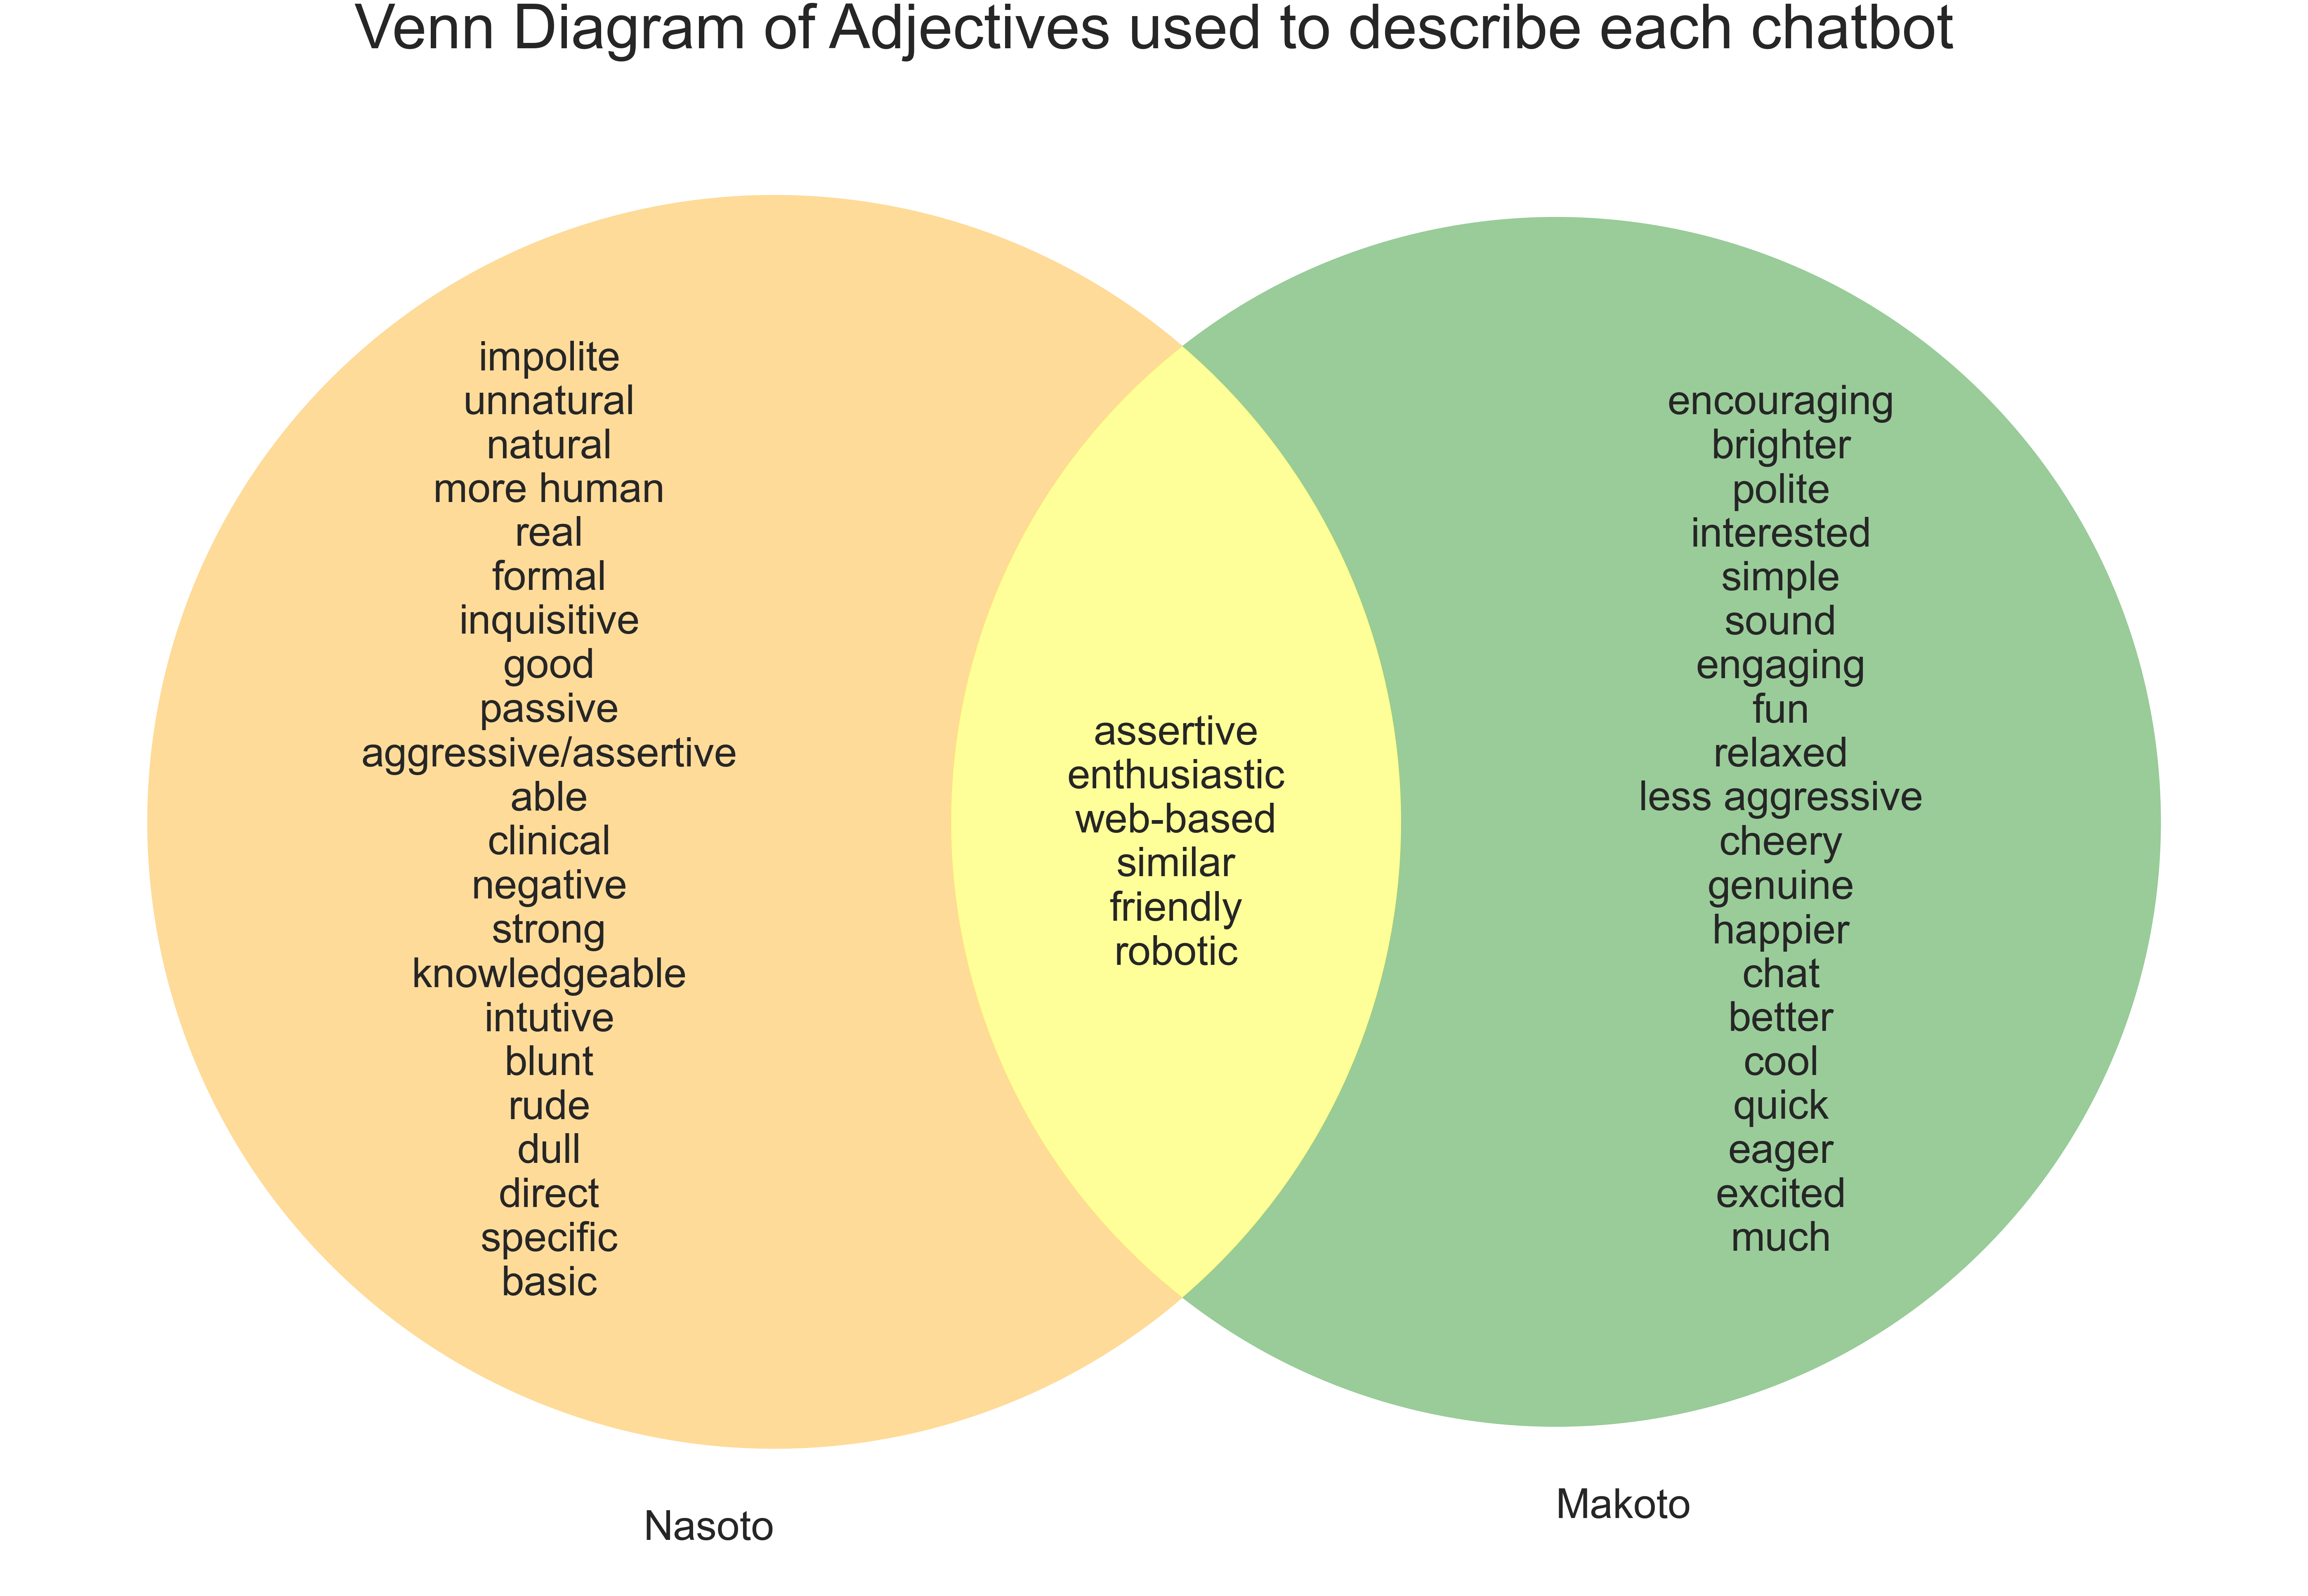

In [215]:
import math, itertools
from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn3
plt.figure(figsize=(100, 110))
plt.title('Venn Diagram of Adjectives used to describe each chatbot').set_fontsize(150)
makotoSet = set(makoto_adj)
nasotoSet = set(nasoto_adj)

s = [nasotoSet, makotoSet]

def gen_index(n):
    x = -1
    while True:       
        while True:
            x = x + 1
            if bin(x).count('1') == n:
                break
        yield x
def make_intersections(sets):
    l = [None] * 2**len(sets)
    for i in range(1, len(sets) + 1):
        ind = gen_index(i)
        for subset in itertools.combinations(sets, i):
            inter = set.intersection(*subset)
            l[next(ind)] = inter
    return l
def bits2indices(b):
    l = []
    if b == 0:
        return l
    for i in reversed(range(0, int(math.log(b, 2)) + 1)):
        if b & (1 << i):
            l.append(i)
    return l
def number2venn_id(x, n_fill):
    id = bin(x)[2:].zfill(n_fill)
    id = id[::-1]
    return id

def sets2dict(s):
    l = make_intersections(s)
    d = {}
    for i in range(1, len(l)):
        d[number2venn_id(i, len(s))] = l[i]
        for j in range(1, len(l)):
            if bin(j).count('1') < bin(i).count('1'):
                l[j] = l[j] - l[i]
                d[number2venn_id(j, len(s))] = l[j] - l[i]
    return d
# Create dictionary from sets
d = sets2dict(s)

h = venn2(s, ('Nasoto', 'Makoto'))
for text in h.set_labels:
    text.set_fontsize(100)
h.get_patch_by_id('01').set_color('green')
h.get_patch_by_id('10').set_color('orange')
h.get_patch_by_id('11').set_color('yellow')
for k, v in d.items():
    l = h.get_label_by_id(k)
    if l:
        l.set_text('\n'.join(map(str, v)))
        l.set_fontsize(100)

plt.show()

### Demographic Perception of the Chatbots

In [218]:
def find_PRP(keyword):
    if (pd.isnull(keyword)):
        return ''
    else:
        tokens = nltk.word_tokenize(keyword.lower())
        tagged = nltk.pos_tag(tokens)
        adjective = [w for w,t in tagged if ("PRP") in t]
        if len(adjective) < 1:
            return ''
        else:
            return adjective[0]

In [238]:
# Look at the use of personal pronouns 
df_descriptions = []
# Makoto manually add adjectives
df_descriptions = (df_merged['Expand on your answer (optional)_x'].apply(find_PRP))
df_descriptions = df_descriptions.append(df_merged['Expand on your answer (optional).1_x'].apply(find_PRP))
df_descriptions = df_descriptions.append(df_merged['Expand on your answer (optional).2_x'].apply(find_PRP))
df_descriptions = df_descriptions.append(df_merged['Did you enjoy your interaction with Makoto?'].apply(find_PRP))

# Nasoto manually add adjectives
df_descriptions = df_descriptions.append(df_merged['Expand on your answer (optional)_y'].apply(find_PRP))
df_descriptions = df_descriptions.append(df_merged['Expand on your answer (optional).1_y'].apply(find_PRP))
df_descriptions = df_descriptions.append(df_merged['Expand on your answer (optional).2_y'].apply(find_PRP))
df_descriptions = df_descriptions.append(df_merged['Did you enjoy your interaction with Nasoto?'].apply(find_PRP))

df_descriptions = df_descriptions.append(df_merged['Did you notice any differences in your interactions with one chatbot over the other? If so what were they.'].apply(find_PRP))
df_descriptions = df_descriptions.append(df_merged['Which chatbot did you prefer interacting with?'].apply(find_PRP))
df_descriptions = df_descriptions.append(df_merged['Explain why you preferred interacting with this chatbot?'].apply(find_PRP))

In [239]:
def wordListToFreqDict(wordlist):
    wordfreq = [wordlist.count(p) for p in wordlist]
    return dict(list(zip(wordlist,wordfreq)))

In [240]:
wordListToFreqDict(list(df_descriptions))

{'it': 40,
 'they': 6,
 '': 122,
 'its': 1,
 'you': 3,
 'my': 4,
 'he': 4,
 'me': 3,
 'them': 1,
 'your': 2,
 'their': 1}

### How Particiapants who prefer Nasoto preceive Nasoto (why they preferred)

In [268]:
row_indexes=df_merged[df_merged['Chatbot_binary']==1].index 
for row in row_indexes:
    print(df_merged["Explain why you preferred interacting with this chatbot?"][row])

The conversation I had with Nasoto felt two-sided. I had the feeling that Nasoto was reading and interpreting what I was typing. With Makoto, it felt like a one-sided conversation where I was doing all the talking 
Nasoto seemed to know more about the modules. Provided more of a personalized experience.
It was engaging more in the conversation
There was one error with Makoto where the conversation was restarted
I felt as though it was a more natural conversation, the first chatbot seemed more automated


### How Particiapants who prefer Makoto preceive Nasoto

In [270]:
row_indexes=df_merged[df_merged['Chatbot_binary']==0].index 
for row in row_indexes:
    print(df_merged["Describe Nasoto"][row])

Nasoto was pretty formal, it felt like I was being interviewed for RTÉ News (not in a bad way). They did a pretty good job at responding to my messages.
it was more specific when asking questions and gave me examples which I found helpful. But some of the questions I wouldn't answer.
Sort of direct and would ask/repeat questions after saying "Bye", could be a bug? 
Nasoto seems very basic, a lot of the interaction felt un-natural and anticipated. Nasoto is quick to respond although there were some issues where it couldnt understand "8" but could understand "eight"
very formal, not as friendly as makoto. struggled to understand phrases more than makoto
Nasoto seems like a good chat bot. Talking to Nasoto was similar to taking an oral exam when studying a language module, in the way Nasoto asks about your university life.
It felt very assertive,
Robotic
Nasoto is a chatbot that discussed my UCD experience
felt like a real person to talk to about simple university life.
Nasoto was really 

### How Particiapants who prefer Nasoto preceive Makoto

In [272]:
row_indexes=df_merged[df_merged['Chatbot_binary']==1].index 
for row in row_indexes:
    print(df_merged["Describe Makoto"][row])

A web-based chat application
A chatbot which asks the user about their modules at university. 
Bland
Quite similar to Nasoto
It was very quick, I think it was quite obvious that they were automated responses and not personalised, as I asked a question and the response was not in accordance with this


### How Particiapants who prefer Makoto preceive Makoto (why they preferred)

In [274]:
row_indexes=df_merged[df_merged['Chatbot_binary']==0].index 
for row in row_indexes:
    print(df_merged["Explain why you preferred interacting with this chatbot?"][row])

They were just more fun and relaxed and it was a much more pleasant conversation.
it is not rude and the questions it asked allowed for more options to respond in. The question on facilities I was only thinking about the ones it listed only (even tho it said etc.)
More interesting to interact with due to a brighter "personality"
Makoto is more cheery, nasoto seems to not respond to your actual response but follows a more clinical approach
resulted in a better, more interesting conversation

Makoto seemed nicer and more excited to talk than Nasoto
It was sounder to chat to. Better personality 
Better understanding
Their attitude
i preferred it because of its conversational energy, it felt like i was chatting to a friend.
Just seemed to work better
He was more friendly and the conversation was better
